In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### LOAD DATA ###

label = pd.read_csv('profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)    

print(df.shape)
df.head()

(8820, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391


In [4]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 60, 4)

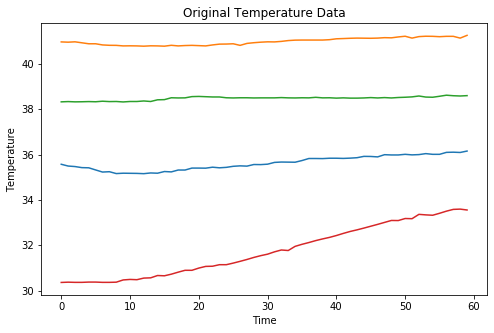

In [5]:
### PLOT ORIGINAL TEMPERATURE DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[0])
plt.title('Original Temperature Data')
plt.ylabel('Temperature'); plt.xlabel('Time')
np.set_printoptions(False)

In [6]:
### LABEL DISTRIBUTION ###

label = label.Cooler
label.value_counts()

100    741
3      732
20     732
Name: Cooler, dtype: int64

In [7]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{3: 0, 20: 1, 100: 2}
{0: 3, 1: 20, 2: 100}


In [8]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state = 42, test_size=0.2)

In [9]:
### SCALE DATA ###

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# MODEL

In [10]:
num_sensors = 4
TIME_PERIODS = 60
BATCH_SIZE = 16
EPOCHS = 10

model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.5))
model_m.add(Dense(3, activation='softmax'))

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_m.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

Train on 1411 samples, validate on 353 samples
Epoch 1/10
1411/1411 - 3s - loss: 0.2305 - accuracy: 0.9298 - val_loss: 0.0763 - val_accuracy: 0.9802
Epoch 2/10
1411/1411 - 1s - loss: 0.1263 - accuracy: 0.9752 - val_loss: 0.0900 - val_accuracy: 0.9802
Epoch 3/10
1411/1411 - 1s - loss: 0.1061 - accuracy: 0.9745 - val_loss: 0.0705 - val_accuracy: 0.9887
Epoch 4/10
1411/1411 - 1s - loss: 0.1074 - accuracy: 0.9787 - val_loss: 0.0683 - val_accuracy: 0.9802
Epoch 5/10
1411/1411 - 1s - loss: 0.1080 - accuracy: 0.9794 - val_loss: 0.0686 - val_accuracy: 0.9858
Epoch 6/10
1411/1411 - 1s - loss: 0.1250 - accuracy: 0.9688 - val_loss: 0.0615 - val_accuracy: 0.9802
Epoch 7/10
1411/1411 - 1s - loss: 0.1201 - accuracy: 0.9702 - val_loss: 0.0567 - val_accuracy: 0.9858
Epoch 8/10
1411/1411 - 1s - loss: 0.1032 - accuracy: 0.9759 - val_loss: 0.1024 - val_accuracy: 0.9830
Epoch 9/10
1411/1411 - 1s - loss: 0.1059 - accuracy: 0.9787 - val_loss: 0.0952 - val_accuracy: 0.9773
Epoch 10/10
1411/1411 - 1s - loss: 

In [11]:
model_m.evaluate(X_test, y_test, verbose=2)

441/1 - 0s - loss: 0.0553 - accuracy: 0.9887


[0.09616101724718636, 0.9886621]

In [12]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model_m.predict(X_test), axis=1)

In [13]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       152
          20       0.98      0.99      0.98       135
         100       1.00      0.99      0.99       154

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



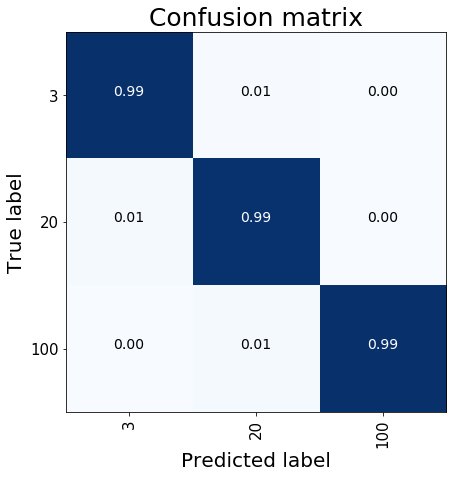

In [14]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()

# VISUAL REPRESENTATION

In [15]:
### MAKE A MODEL FOR EMBEDDINGS ###
emb_model = Model(inputs=model_m.input, outputs=model_m.get_layer('G_A_P_1D').output)
emb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 60, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 100)           2500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0     

In [16]:
### EXTRACT EMBEDDINGS ###
serie_features = emb_model.predict(X_test)

In [17]:
### VISUALIZE EMBEDDINGS ###
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(serie_features)

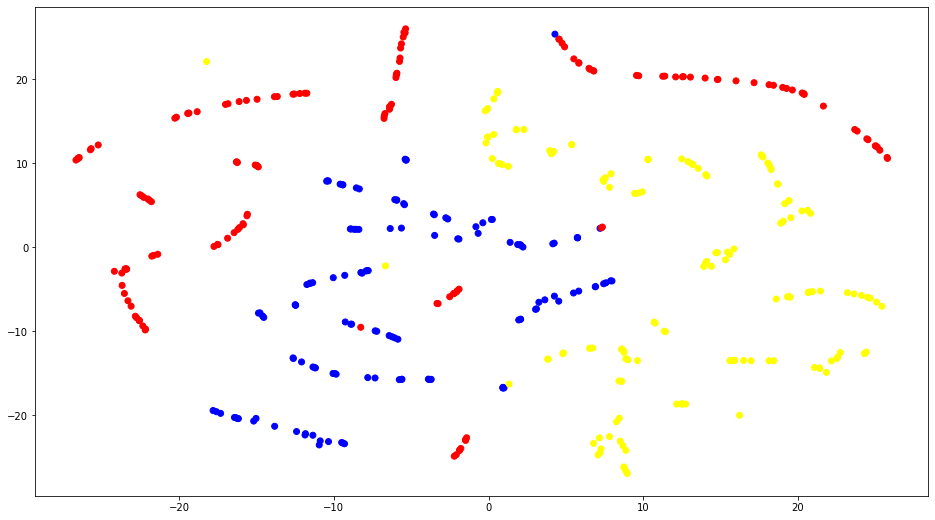

In [18]:
plt.figure(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'yellow'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.argmax(y_test, axis=1)]) 
plt.show()